In [2]:
import numpy as np 
import pandas as pd
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime

%matplotlib inline     
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from matplotlib.pylab import rcParams

from timeseries.utils import *
from timeseries.plot import *
from timeseries.model import *

# Register converters to avoid warnings
pd.plotting.register_matplotlib_converters()
plt.rc("figure", figsize=(12,8))
plt.rc("font", size=11)

<a class="anchor" id="0.1"></a>
# **Table of Contents**

In the previous notebook (01-intro-time-series.ipynb) you were introduced to time series, how to decompose and identify important properties such as trend, seasonality, and stationarity. In this notebook we will learn about ARIMA models and their variants SARIMA and ARIMAX.

More specifically, we will learn:

<li>What a White Noise/ Random Walk model are</li>
<li>What a autoregressive and moving average are</li>
<li>When to use ARIMA, SARIMA, or ARIMAX</li>
<li>How to fit (S)ARIMA(X) model</li>
<li>How to optimize (S)ARIMA(X) model</li>
<li>How to make forecasts</li>
<li>How to evaluate the obtained model</li>

In [3]:
file = 'input/sale_values.csv'
df = pd.read_csv(file)
df = process_data(df)
df.head(5)

,index,Period,Revenue,Sales_quantity,Average_cost,The_average_annual_payroll_of_the_region,Date
0,0,01.01.2015,1.601007e+07,12729.0,1257.763541,30024676.0,2015-01-01
1,1,01.02.2015,1.580759e+07,11636.0,1358.507000,30024676.0,2015-02-01
2,2,01.03.2015,2.204715e+07,15922.0,1384.697024,30024676.0,2015-03-01
3,3,01.04.2015,1.881458e+07,15227.0,1235.606705,30024676.0,2015-04-01
4,4,01.05.2015,1.402148e+07,8620.0,1626.621765,30024676.0,2015-05-01


# **1. Time Series Statistical Models** <a class="anchor" id="1"></a>

## 1.1 White noise model

White noise are variations in your data that cannot be explained by any regression model

Properties:
- Fixed/const mean
- Fixed/const variance
- No correlation over time (pattern is random)

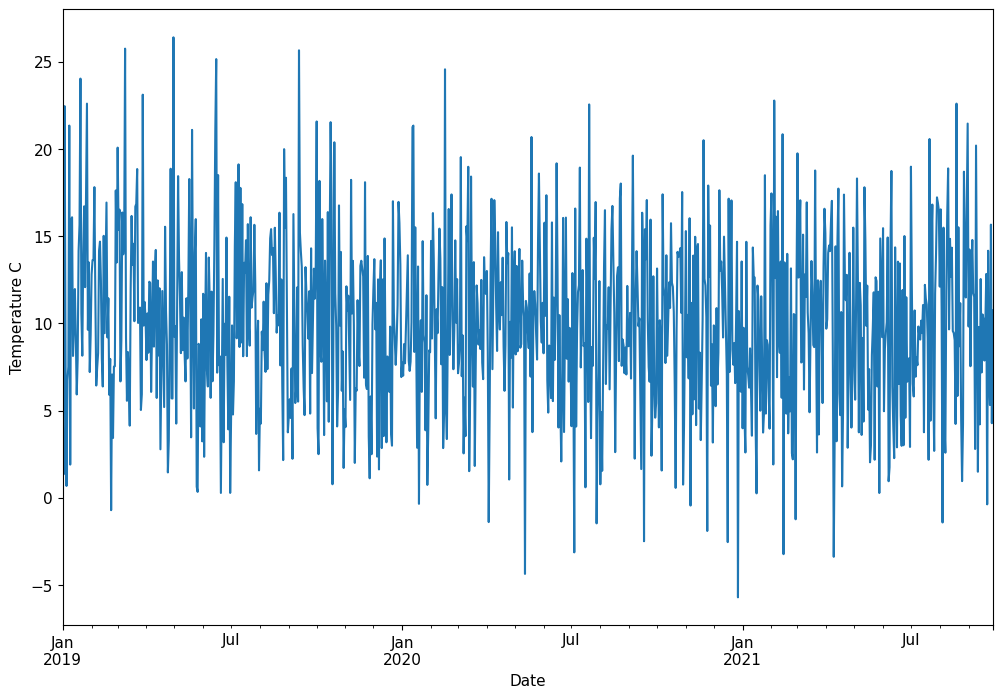

In [4]:
n = 1001
date_series = pd.date_range(start='1/1/2019', periods=n)
avg_temp = 10
std_temp = 5
temp_series = np.random.normal(avg_temp,std_temp,n)

# create time series
temp_time_series = pd.Series(data = temp_series, index=date_series)

# plot
ax = temp_time_series.plot(figsize=(12,8))
ax.set_xlabel('Date')
ax.set_ylabel("Temperature C")
plt.show()

## 1.2 Random walk

it assumes that, at each point in time, the series merely takes a random step away from its last recorded position

Properties:
- No specified mean/variance
- Strong dependence over time

**`Random walk without a drift`**
is a stochastic process where the future value of the process is determined by the current value of the process plus a random error term, where the error term has a zero mean and constant variance

Formula:
$Y(t) = Y(t-1) + e(t)$

$e(t)$: white noise with mean = 0

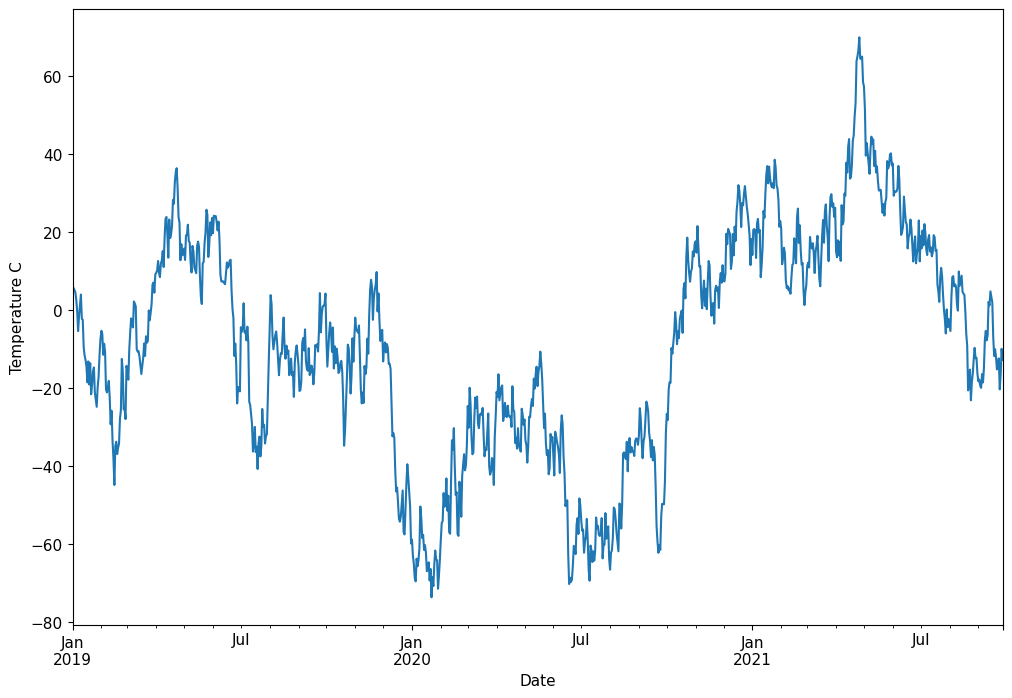

In [5]:
# Without a drift
n_days = 1001
avg_temp = 0
std_temp = 5
date_series = pd.date_range(start='1/1/2019', periods=n_days)

# create time series
epsi = np.random.normal(avg_temp,std_temp,n)
y0 = 0
vals = y0 + np.cumsum(epsi)
temp_time_series = pd.Series(data = vals, index=date_series)

# plot
ax = temp_time_series.plot(figsize=(12,8))
ax.set_xlabel('Date')
ax.set_ylabel("Temperature C")
plt.show()

**`Random walk with a drift`** is a mathematical model used to describe the behavior of a time series in which each value is determined by the previous value plus a random error term and a constant value called the drift.

Formula:
$Y(t) = a + Y(t-1) + e(t)$

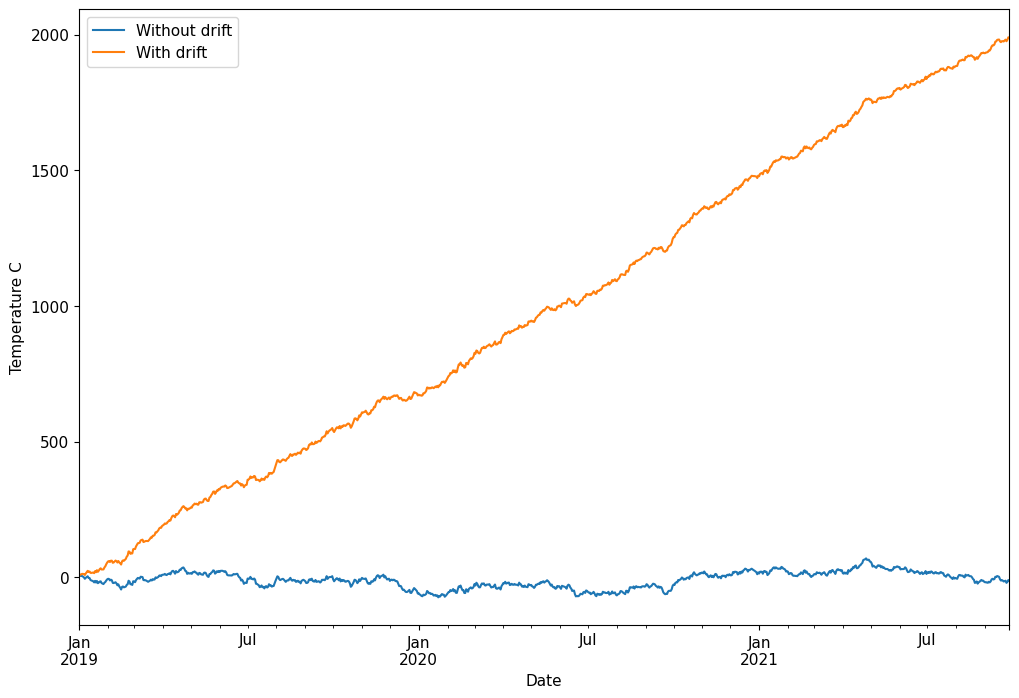

In [6]:
# With a drift
c = 2

# create time series
vals_drift = y0 + np.cumsum(c+ epsi)
temp_time_series_drift = pd.Series(data = vals_drift, index=date_series)

# plot
ax = temp_time_series.plot(figsize=(12,8))
temp_time_series_drift.plot()
ax.set_xlabel('Date')
ax.set_ylabel("Temperature C")
ax.legend(['Without drift', 'With drift'])
plt.show()

In summary, the main difference between random walk and white noise is that random walk is a process where the value at each time step depends on the previous value, while white noise is a process where each value is completely random and independent of previous values.

## 1.3 Moving average

The moving average (MA) model is a commonly used statistical model in time series analysis. It is a way to model the behavior of a time series based on the past observations. We might replace the white noise series wt by a moving average that smooths the series.

The basic idea behind the MA model is to estimate the current value of a time series as a linear combination of its past values, with a weighted average where the weights decrease as the observations get older. The weights assigned to the past observations are often referred to as the "coefficients" of the MA model.

$$ Y_t = c + e_t + θ_1 e_{t-1} + θ_2 e_{t-2} + ... + θ_q e_{t-q}$$

where $Y_t$ is the current observation, $c$ is a constant, $e_t$ is a white noise error term at time $t$, and $θ_1, θ_2, ..., θ_q$ are the coefficients of the MA model. The value of $q$ represents the number of past observations that are taken into account in the model.

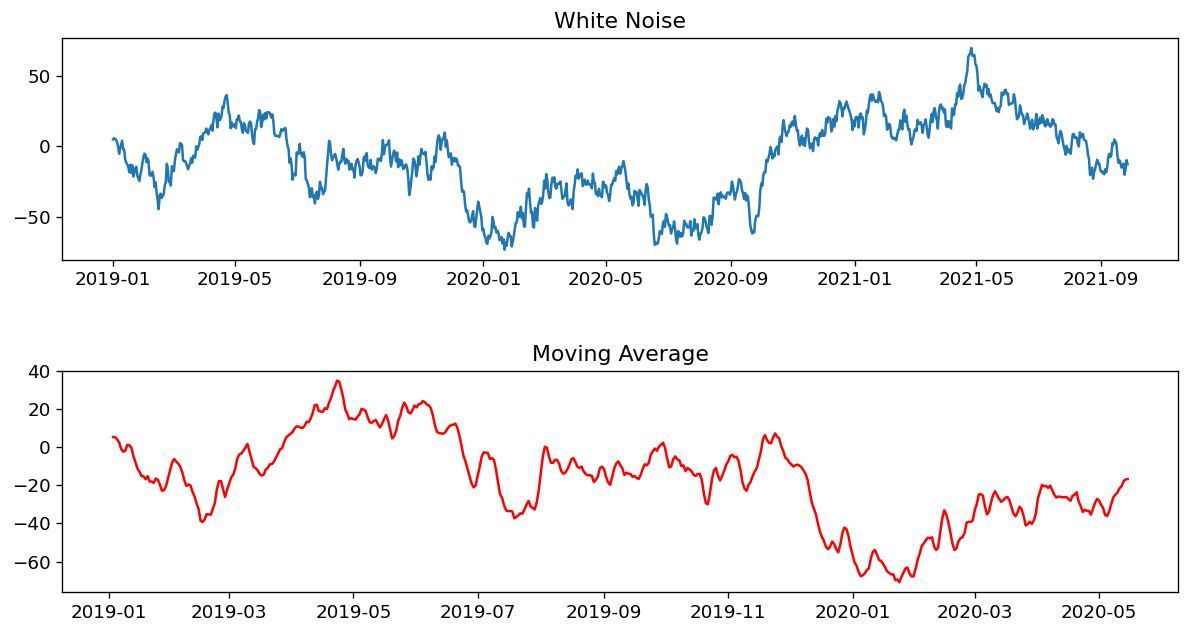

In [15]:
movingAverage = temp_time_series.rolling(window=3).mean()

MA_timeserires= pd.Series(data = movingAverage, index=date_series)

fig, (ax1, ax2)  = plt.subplots(2, 1, figsize=(12,6), dpi=120)
fig.subplots_adjust(hspace=0.5)
ax1.plot(temp_time_series)
ax1.set_title('White Noise')

ax2.plot(MA_timeserires, color = 'red')
ax2.set_title('Moving Average')

plt.show()

## 1.4 Autoregression

The autoregressive (AR) model is a commonly used statistical model in time series analysis. It is a way to model the behavior of a time series based on its past values, where the current value of the time series is regressed on its past values.

The basic idea behind the AR model is to estimate the current value of a time series as a linear combination of its past values, with the weights of the past values determined by the coefficients of the model. The coefficients represent the strength and direction of the influence of each past value on the current value.

$$Y_t = c + φ_1 Y_{t-1} + φ_2 Y_{t-2} + ... + φ_p Y_{t-p} + e_t$$

where $Y_t$ is the current observation, $c$ is a constant, $φ_1, φ_2, ..., φ_p$ are the coefficients of the AR model, and $e_t$ is a white noise error term at time t. The value of $p$ represents the number of past observations that are taken into account in the model.

- $φ_1, φ_2, ..., φ_p = 0 $ simply the white noise model
- $φ_1, φ_2, ..., φ_p < 0 $ oscillate
- $φ_1, φ_2, ..., φ_p > 0 $ previous point correlates with past


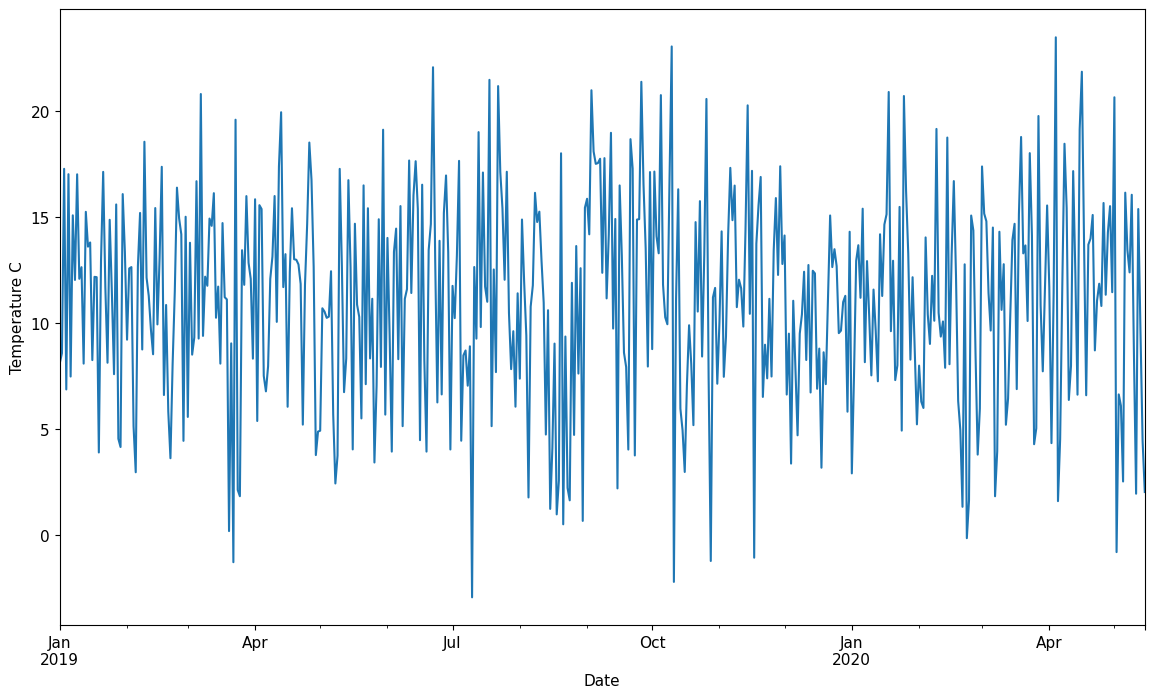

In [8]:
# Without a drift
n_days = 501
avg_temp = 0
std_temp = 5
date_series = pd.date_range(start='1/1/2019', periods=n_days)
# 
mu = 10
phi = 0.1
# phi = 0.5
# phi = 0.9
# phi = -1.05
# phi = -0.5
# phi = -0.9
epsi = np.random.normal(avg_temp,std_temp,n_days)

# create time series
vals  = []
y = 0
for e in epsi:
    y = y * phi + e + mu
    vals.append(y)

AR_time_series = pd.Series(data = vals, index=date_series)

# plot
ax = AR_time_series.plot(figsize=(14,8))
ax.set_xlabel('Date')
ax.set_ylabel("Temperature C")
plt.show()

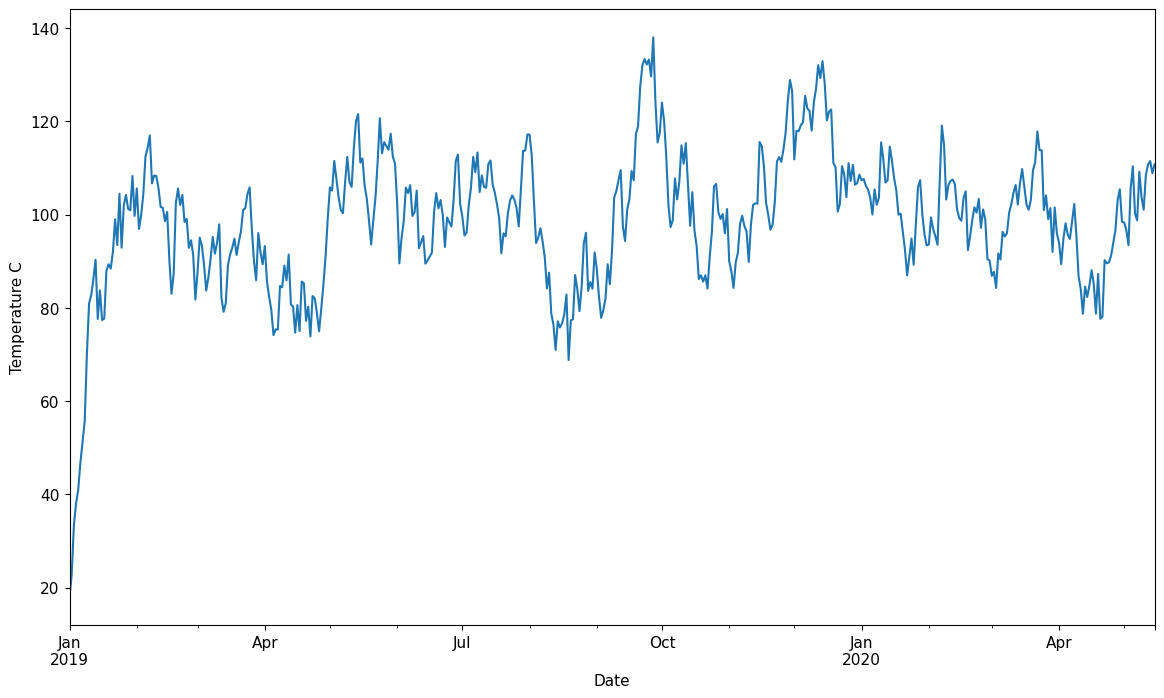

In [16]:
# Without a drift
phi = 0.9
# phi = -1.05
# phi = -0.5
# phi = -0.9
epsi = np.random.normal(avg_temp,std_temp,n_days)

# create time series
vals  = []
y = 0
for e in epsi:
    y = y * phi + e + mu
    vals.append(y)

AR_time_series = pd.Series(data = vals, index=date_series)

# plot
ax = AR_time_series.plot(figsize=(14,8))
ax.set_xlabel('Date')
ax.set_ylabel("Temperature C")
plt.show()

<div class="alert alert-block alert-info">
<b> Notes</b> 

`A random walk model` can be seen as a `special case` of an autoregressive model in which the **`autoregressive parameter`** is equal to **`one`**. This means that the current value of a random walk is equal to the previous value plus a random error term. In other words, a random walk is a type of autoregression where the autoregressive parameter is one.

`White noise` can be seen as a `special case` of both autoregression and random walk models, where the **`autoregressive parameter`** is equal to **`zero`**. This means that the current value of the series is only dependent on the current error term, and the past values of the series have no effect on the future values. In other words, white noise is a type of time series where there is no autocorrelation between the past and future values.
</div>


# **1. ARIMA Model** <a class="anchor" id="2"></a>

ARIMA means **A**uto **R**egressive **I**ntegrated **M**oving **A**verage. It is a combination of two models: `AR (Auto Regressive)` model which uses lagged values of the time series to forecast and `MA (Moving Average)` model that uses lagged values of residual errors to forecast. In other words, this model uses dependencies both between data values and errors values from the past to optimize the predictions. 

ARIMA uses three parameters - `ARIMA(p,d,q)`:

- Auto Regressive term **p**: Number of autoregressive lags

- Order of differencing term **d**: Number of times differencing pre-processing step is applied to make the time series stationary

- Moving Average term **q**: Number of moving average lags

We cannot model a time series if it is not stationary. However, we can apply some transformation such as differencing to make a time series stationary, as seen previously in [01-intro-time-series.ipynb](01-intro-time-series.ipynb). The parameter **d** allow us to apply differencing within ARIMA. 

It is also possible to apply transformations before applying ARIMA in order to make time series stationary. However, when applying differencing in this way we are forecasting on the transformed data; therefore we need to reverse the transformation in order to access the forecast of the original values.

We must be careful about selecting the right amount of differencing. We difference the data only until it is stationary and no more. To help choosing the amount of differencing, i.e., the value of parameter **d** we can use the [Augmented Dickey-Fuller (ADF) test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test) and [Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test](https://en.wikipedia.org/wiki/KPSS_test). For example, by applying the following function presented at the previous notebook:

## ARIMAX


ARIMA means **A**uto **R**egressive **I**ntegrated **M**oving **A**verage. It is a combination of two models: `AR (Auto Regressive)` model which uses lagged values of the time series to forecast and `MA (Moving Average)` model that uses lagged values of residual errors to forecast. In other words, this model uses dependencies both between data values and errors values from the past to optimize the predictions. 

ARIMA uses three parameters - `ARIMA(p,d,q)`:

- Auto Regressive term **p**: Number of autoregressive lags

- Order of differencing term **d**: Number of times differencing pre-processing step is applied to make the time series stationary

- Moving Average term **q**: Number of moving average lags

We cannot model a time series if it is not stationary. However, we can apply some transformation such as differencing to make a time series stationary, as seen previously in [01-intro-time-series.ipynb](01-intro-time-series.ipynb). The parameter **d** allow us to apply differencing within ARIMA. 

It is also possible to apply transformations before applying ARIMA in order to make time series stationary. However, when applying differencing in this way we are forecasting on the transformed data; therefore we need to reverse the transformation in order to access the forecast of the original values.

We must be careful about selecting the right amount of differencing. We difference the data only until it is stationary and no more. To help choosing the amount of differencing, i.e., the value of parameter **d** we can use the [Augmented Dickey-Fuller (ADF) test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test) and [Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test](https://en.wikipedia.org/wiki/KPSS_test). For example, by applying the following function presented at the previous notebook:

## ARIMAX

It is also possible to extend the ARIMA model to use e**x**ogenous inputs and create an ARIMAX model. In this model the time series is modeled using other independent variables as well as the time series itself. 

For example, when modeling the waiting time in an emergency room. The number of nurses available at a certain shift could be considered an external variable since it may impact on the waiting time. If this is indeed the case, by changing the number of nurses we can affect the waiting times. 

## SARIMA

If there is seasonality a `SARIMA (Seasonal ARIMA)` model should be used. When applying an ARIMA model, we are ignoring seasonality and using only part of the information in the data. As a consequence, we are not making the best predictions possible.

SARIMA models include extra parameters related to the seasonal part. Indeed, we can see a SARIMA model as two ARIMA models combined: one dealing with non-seasonal part and another dealing with the seasonal part.

Therefore, a SARIMA(p,d,q)(P,D,Q,S) model have all the parameters described above (non-seasonal parameters) and P,D,Q,S that are the seasonal parameters, i.e.,

* **Non-seasonal orders**

   - p: Autoregressive order
   - d: Differencing order
   - q: Moving average order

* **Seasonal orders**

    - P: Seasonal autoregressive order
    - D: Seasonal differencing order
    - Q: Seasonal moving average order
    - S: Length of the seasonal cycle
 
## 2.1 The ACF and PACF 
Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) are used to figure out the order of AR, MA, and ARMA models.
Though ACF and PACF do not directly dictate the order of the ARMA model, the plots can facilitate understanding the order and provide an idea of which model can be a good fit for the time-series data

**ACF plot** is a bar chart of coefficients of correlation between a time series and it lagged values. Simply stated: ACF explains how the present value of a given time series is correlated with the past (1-unit past, 2-unit past, …, n-unit past) values. In the ACF plot, the y-axis expresses the correlation coefficient whereas the x-axis mentions the number of lags. Assume that, $y(t-1), y(t), y(t-1),….y(t-n)$ are values of a time series at time $t, t-1,…,t-n,$ then the lag-1 value is the correlation coefficient between $y(t)$ and $y(t-1),$ lag-2 is the correlation coefficient between $y(t)$ and $y(t-2)$ and so on.

**PACF** is the partial autocorrelation function that explains the partial correlation between the series and lags itself. In simple terms, PACF can be explained using a linear regression where we predict *y(t)* from $y(t-1), y(t-2),$ and $y(t-3)$ [2]. In PACF, we correlate the “parts” of y(t) and y(t-3) that are not predicted by y(t-1) and y(t-2).

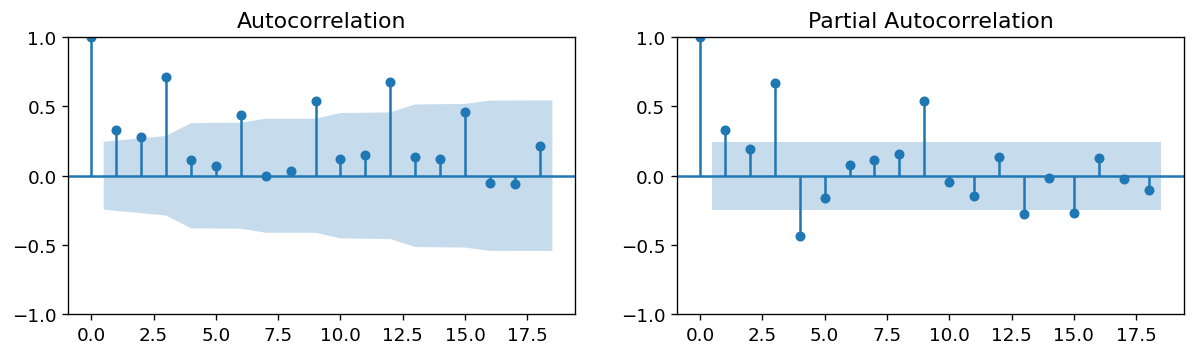

In [9]:
acf_pacf_plot(df['Sales_quantity'].dropna())

## ACF Plot to Determine Seasonal Period
Previously, we got a hint from the ACF plot that our time series has a seasonal period of 7, i.e., S=7. 

Therefore, the ACF plot can help in finding out the time period, especially if it is not clear from the plots of the time series. 

**Important:** Make time series stationary first.

## Seasonal Differencing

We have also learnt that in order to make a time series stationary we may use differencing and that's how we determine the parameter `d` of ARIMA, together with ADF test.

For a seasonal time series, we may need to apply seasonal differencing. In seasonal differencing, instead of subtracting the most recent time series value, we subtract the time series value from one cycle ago. Therefore, if the time series shows a trend, then we take the normal difference. If there is a strong seasonal cycle, then we will also take the seasonal difference.

Furthermore, in the case of strong seasonality, as observed in our time series, `D=1`. A rule of thumb is that d + D should not be greater than 2.

Once we have found the two orders of differencing, `d` and `D`, and made the time series stationary, we need to find the other model orders. 

As before, to find non-seasonal orders `p`and `q` a plot ACF and PACF of differenced time series can be used. However, to find seasonal orders `P` and `Q` we need to plot ACF and PACF of the differenced time series at multiple seasonal steps.

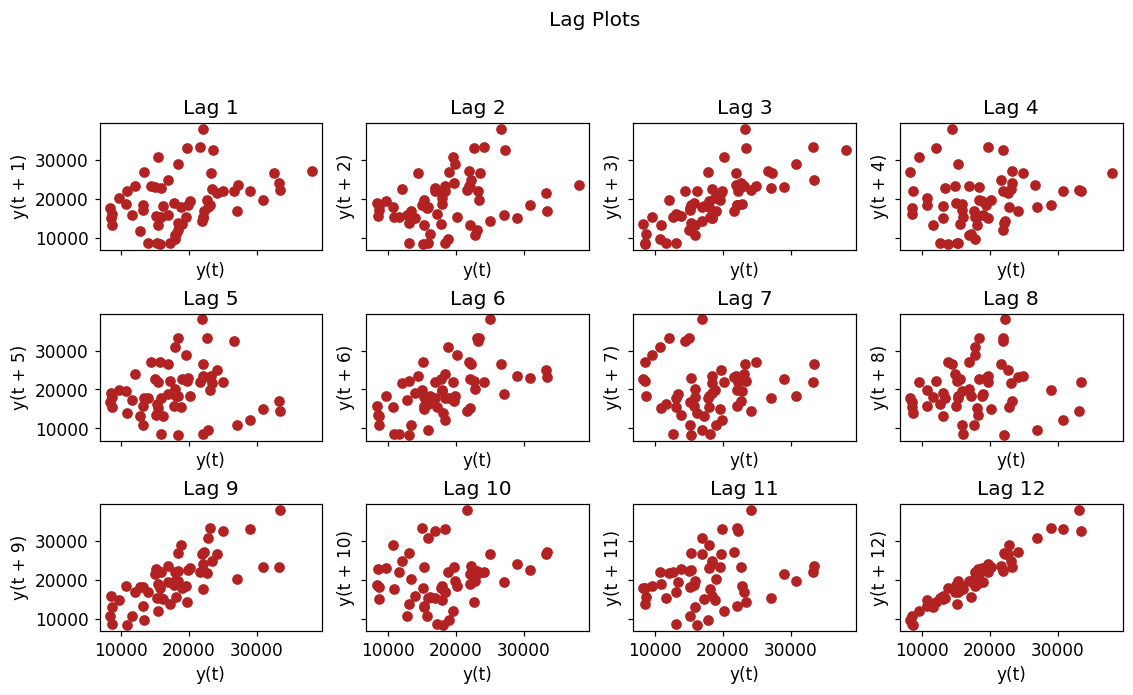

In [10]:
lag_plots(df['Sales_quantity'].dropna())

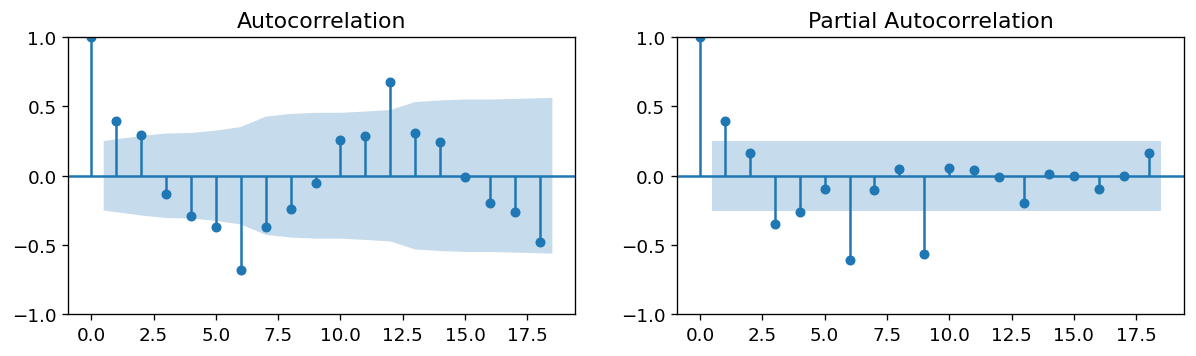

In [11]:
df = nDifferencing(df,3)
acf_pacf_plot(df['3-orderdiff'])


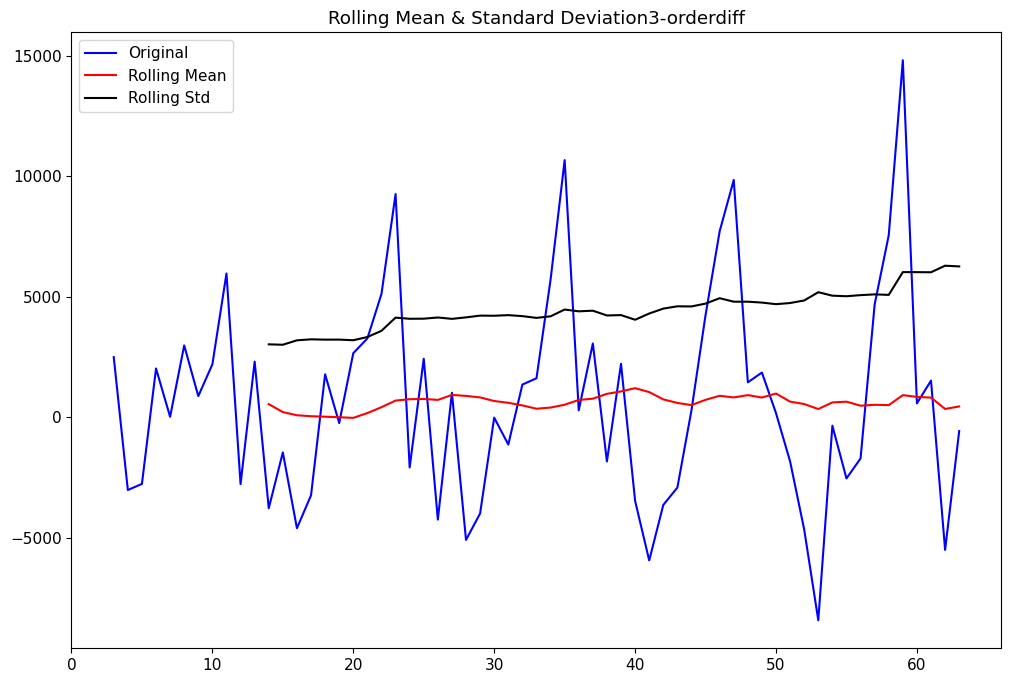

Results of Dickey Fuller Test:
ADF Statistic: -9.048306
p-value: 0.000000
Critical Values:
	1%: -3.563
	5%: -2.919
	10%: -2.597


In [12]:
rolling_statistics_graph(df, columnname='3-orderdiff')
test_stationarity(df['3-orderdiff'].dropna())


## STEP 2: Estimate Coefficients (p,q)

Although we had clear signs that we need a SARIMA model, we will start by applying a ARIMA model instead. By doing so we can obtain a better understanding on the differences between ARIMA and SARIMA in what concern the use of Box-Jenkins’s method. In addition, it will be clear the advantages of choosing the appropriate model.

ACF and PACF plots can help us find appropriate values for parameters `p` and `q` . However, the interpretation of these plots is not always clear. To obtain more assurance to our choices we can apply an empirical method. This method consists on fitting the ARIMA model for different values of p and q, and choosing the best value based on metrics such as AIC and BIC.

`AIC (Akaike information criterion)` is a metric which tells us how good a model is. Lower the value, better the model. The AIC also penalizes models which have lots of parameters. This means if we set the order too high compared to the data, we will get a high AIC value. This stops us overfitting to the training data. 

`BIC (Bayesian information criterion)` is similar to AIC, therefore lower value means a better model. However, BIC penalizes additional model orders more than AIC. As consequence, BIC will sometimes suggest a simpler model. 

After fitting a model, we can access its summary statistics, and there is where we can find the values of AIC and BIC.

Usually there is agreement between AIC and BIC. If there is no agreement choose smaller AIC if you prefer a predictive model. Otherwise, choose smaller BIC for an explanatory model.

In [13]:
from pmdarima.arima import auto_arima
# (p, d, q) (P, D, Q)
decomposition = auto_arima(df['Sales_quantity'].dropna(), 
                            start_p=1,
                            start_q=1,
                            max_p=2,#max value of p to test
                            max_q=2,
                            start_P=0,
                            start_Q=0,
                            m=12,#the seasonal period - month
                            d=1, #non-seasonal difference order, 
                            D=1, #seasonal difference order
                            seasonal=True,# is the time series seasonal
                            trace=True, # prints the information_criterion for each model it fits
                            error_action='ignore', # ignore orders that don't work
                            suppress_warnings=True,
                            stepwise=True # apply an intelligent order search
                            )
order = decomposition.get_params()['order']
seasonal_order = decomposition.get_params()['seasonal_order']

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=925.478, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=927.532, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=926.705, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=924.996, Time=0.24 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=923.669, Time=0.06 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=926.151, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=928.120, Time=0.22 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=925.112, Time=0.09 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=925.832, Time=0.03 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=925.780, Time=0.14 sec
 ARIMA(0,1,1)(0,1,0)[12] intercept   : AIC=925.581, Time=0.06 sec

Best model:  ARIMA(0,1,1)(0,1,0)[12]          
Total fit time: 1.127 seconds


In [14]:
# Create empty list to store search results
order_aic_bic=[]

# Loop over p values from 0-6
for p in range(7):
  # Loop over q values from 0-6
    for q in range(7):
      	# create and fit ARMA(p,q) model
        model = SARIMAX(df, order=(p,1,q), freq="D") #because adf test showed that d=1
        results = model.fit()
        
        # Append order and results tuple
        order_aic_bic.append((p,q,results.aic, results.bic))

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

## **3.Building Models** <a class="anchor" id="3"></a>
https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html

In [ ]:
y_train, y_test = train_test_split(df['Sales_quantity'].dropna(),train_rate=0.9)

In [ ]:
model_fit = train(y_train, order, seasonal_order)
print(model_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                      Sales_quantity   No. Observations:                   58
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 12)   Log Likelihood                -404.158
Date:                             Mon, 20 Feb 2023   AIC                            814.315
Time:                                     14:29:06   BIC                            819.735
Sample:                                          0   HQIC                           816.336
                                              - 58                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift         -0.0790      4.720     -0.017      0.987      -9.331       9.173
ma.L1         -0.2638      

In [ ]:
y_fc = model_fit.forecast(len(y_test.index))
yhat = model_fit.predict()[1:]

In [ ]:
actual_pred_graph(y_test, y_train, yhat, y_fc)

TypeError: actual_pred_graph() takes 2 positional arguments but 4 were given

#### Fit model(0, 1, 1),(0, 1, 0, 2)

In [ ]:
model_fit = train(order=(0, 0, 0), seasonal_order=(0, 1, 1, 12))
print(model_fit.summary())

TypeError: train() missing 1 required positional argument: 'y'

## STEP 3: Model Evaluation

Before, using a model we want to know how accurate it is. Here we present some tools to evaluate the model before considering it the best one and putting it to production.

For this evaluation we focus on the residuals. The residuals are the difference between the model's one-step-ahead predictions and the real values of the time series. 

### Mean Absolute Error (MAE)

We start by calculating the `Mean Absolute Error (MAE)` of the residuals. This will show us how far, on average, the predictions are from the true values.

### Diagnostic Summary Statistics

Another important tool to evaluate the model is the analysis of the residual test statistics in the results summary.

Now we evaluate Prob(Q) and Prob(JB) applying, respectively, the following tests:

[`Ljung–Box test`](https://en.wikipedia.org/wiki/Ljung%E2%80%93Box_test):

**Null hypothesis**: There are no correlations in the residuals.

[`Jarque–Bera test`](https://en.wikipedia.org/wiki/Jarque%E2%80%93Bera_test)

**Null hypothesis**: Residuals are normally distributed.

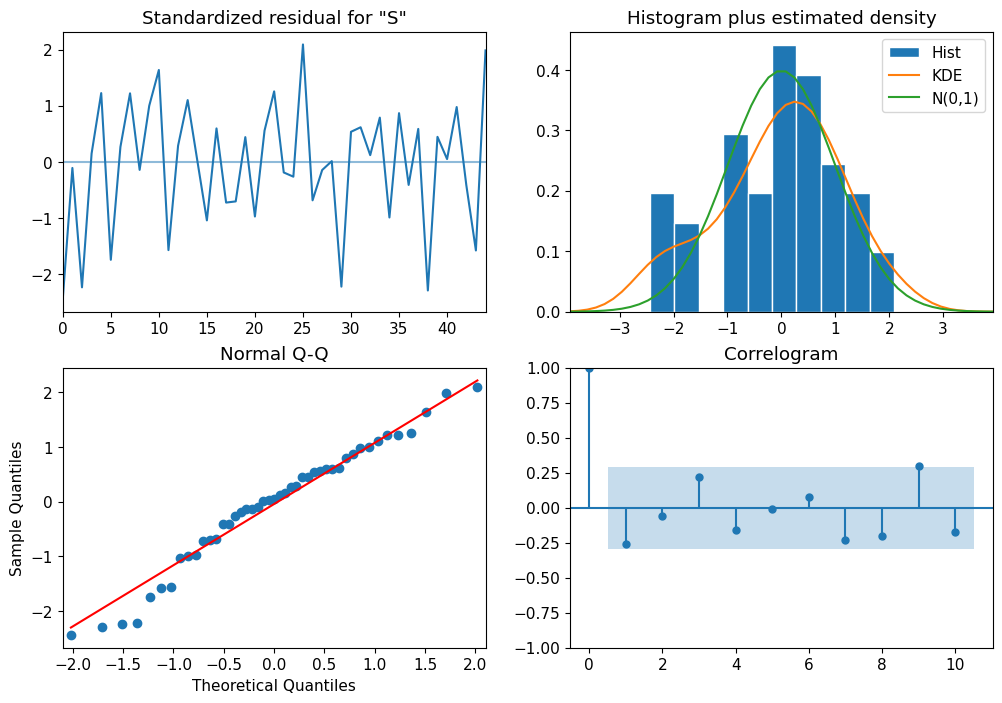

In [ ]:
model_fit.plot_diagnostics()
plt.show()

For an ideal model the residuals should be uncorrelated white Gaussian noise centered on zero. By analyzing the plots above having this in mind we can evaluatearima_results.plot_diagnostics()
plt.show() if we have a good model or not.

So, let's analyze those plots (Clockwise from left-top plot):

* **Standardized residual**: There are no obvious patterns in the residuals. This points out to a good model

* **Histogram plus kde estimate**: The histogram shows the measured distribution of the residuals while the green line shows the KDE curve (smoothed version of the histogram). The green line shows a normal distribution. For a good model the orange line should be similar to the green line. The orange curve is not very similar to the green one.

* **Correlogram** or ACF plot: 95% of correlations for lag greater than one should not be significant (inside the blue area). This is also the case, i.e., good model.

* **Normal Q-Q:** Most of the data points should lie on the straight line, indicating a normal distribution of the residuals. This happens here.

Therefore, all in all the model pointed by our empirical search seems to be a good model.

**Final tips:**

If the residuals are not normally distributed try to increase `d`.

If the residuals are correlated try to increase `p` or `q`.
